# Collaborative, reproducible machine learning for structural biology
##    Fergus Boyles and Fergus Imrie
##    *Department of Statistics, University of Oxford*

# A Python environment for data science

* numpy: Matrix algebra and numerical methods.
* pandas: Data frames for manipulating and visualising data as tables.
* matplotlib: Everybody's favourite Python plotting library.
* seaborn: Statistical visualisation library built on matplotlib and pandas. Lots of high-level functions for data visualisation.
* scikit-learn (sklearn): Machine learning library. Today we'll use its implementations of logistic regression and random forest.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

sns.set(context='notebook', style='white', font_scale=1.8)

In [2]:
%matplotlib inline

# Using existing code within a notebook

We can import a .py file as a module as usual:

In [3]:
import plotting

Or, we can run the contents of a .py file in a cell:

In [4]:
%run plotting.py

If we want to build on existing code, we can load the contents of a .py file into a cell. We can then save our changes if we want to modify the original file:

In [5]:
# %load plotting.py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import auc, roc_curve, confusion_matrix

def draw_confusion_matrix(y_true, y_predicted, class_labels=None, ax=None):
    """Draws a confusion matrix for classifier predictions.
    
    Args:
        y_true (array-like): True class labels
        y_predicted (array-like): Predicted class labels
        class_labels (dict-like, optional): Specify alternative names for each class to use for axis labels
        ax (Matplotlib.Axes, optional): The axes on which to draw the confusion matrix
        
    Returns:
        ax (Matplotlib.Axes): The axes containing the confusion matrix.
    """
    
    if ax is None:
        ax = plt.gca()
    
    cm = pd.DataFrame(confusion_matrix(y_true, y_predicted)).T
    
    if class_labels is not None:
        cm.rename(class_labels, axis='index', inplace=True)
        cm.rename(class_labels, axis='columns', inplace=True)
    
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, annot_kws={'size': 20}, ax=ax)
    ax.set_ylabel('Predicted class label')
    ax.set_xlabel('True class label')

    return ax

def draw_roc_curve(y_true, y_score, annot=True, name=None, ax=None):
    """Draws a ROC (Receiver Operating Characteristic) curve using class rankings predicted by a classifier.
    
    Args:
        y_true (array-like): True class labels (0: negative; 1: positive)
        y_score (array-like): Predicted probability of positive-class membership
        annot (bool, optional): Whether to create and add a label to the curve with the computed AUC
        name (str, optional): Name of the curve to add to the AUC label
        ax (Matplotlib.Axes, optional): The axes on which to draw the ROC curve
        
    Returns:
        ax (Matplotlib.Axes): The axes containing the ROC curve
    """
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    if ax is None:
        ax = plt.gca()
    
    # Add a label displaying the computed area under the curve
    if annot:
        roc_auc = auc(fpr, tpr)
        if name is not None:
            label = f'{name} AUC = {roc_auc:.3f}'
        else:
            label = f'AUC = {roc_auc:.3f}'
    else:
        label=None
    
    ax.plot(fpr, tpr, label=label)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc='best')
    
    return ax


We can use all our usual IPython commands to explore our code:

In [6]:
plotting.draw_confusion_matrix?

Signature: plotting.draw_confusion_matrix(y_true, y_predicted, class_labels=None, ax=None)
Docstring:
Draws a confusion matrix for classifier predictions.

Args:
    y_true (array-like): True class labels
    y_predicted (array-like): Predicted class labels
    class_labels (dict-like, optional): Specify alternative names for each class to use for axis labels
    ax (Matplotlib.Axes, optional): The axes on which to draw the confusion matrix
    
Returns:
    ax (Matplotlib.Axes): The axes containing the confusion matrix.
File:      ~/workspace/3dsig/notebooks/plotting.py
Type:      function


# Data exploration

We read our data straight into a dataframe using Pandas. Jupyter renders dataframes as nice tables, allowing us to look at our data as soon as we load it.

In [7]:
all_data = pd.read_csv('../data/Data_3DSig.txt', sep=' ')
all_data.dropna(axis='index', how='any', inplace=True)

In [8]:
all_data.head()

,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam


In [9]:
split = pd.read_csv('../data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']

# Select target-template pairs where both proteins belong to the 'same family' cluster
targets = split[split['Split']=='FAMILY']['Protein']
data = all_data[(all_data['Target'].isin(targets)) & (all_data['Template'].isin(targets))].copy()

# Drop duplicated rows since we don't know which entry is correct

# 
duplicate_idx = data.duplicated(subset=['Template', 'Target'], keep=False)
duplicates = data.loc[duplicate_idx].sort_values(by=['Target', 'Template'])

# 
data.drop_duplicates(subset=['Template', 'Target'], keep=False, inplace=True)

Many of the plotting functions available through seaborn can operate directly on a pandas dataframe and use the row and column names to automatically annotate the plot. This is a very powerful way to rapidly visualise data during the exploration stage. Here we create a bar plot of the number of examples of each class in the data set, as data imbalance is an important consideration when training and testing a classifier.

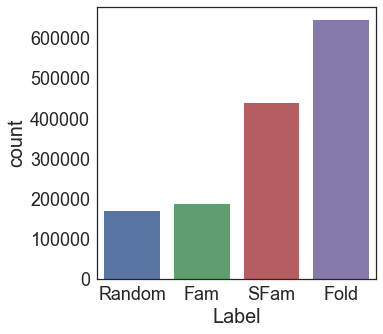

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(data=data, x='Label', order=['Random', 'Fam', 'SFam', 'Fold'], ax=ax)
fig.savefig('bars.pdf', dpi=300)

We're going to focus on the toy problem of distinguishing between proteins that are in the same family and proteins that are completely unrelated. It's worth noting that pandas is not always clear about whether or not it is returning a view or a copy of the contents of a dataframe, so I'm explicitly creating a copy of the subset of the data we want. This lets us play with the data without modifying the original dataframe. In an interactive environment like Jupyter it pays to be careful when manipulating data and carefully document any changes made, as we want to take advatage of the ability to modify individual cells without re-running the entire notebook every time we make a change.

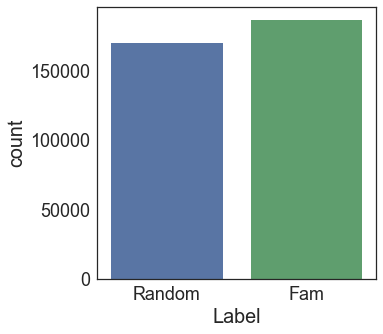

In [14]:
family_data = data[data['Label'].isin(['Fam', 'Random'])].copy()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(data=family_data, x='Label', order=['Random', 'Fam'], ax=ax)

# Training-test split

As our visualisation shows, the data set we'll be using has a good balance of examples of proteins from the same families and proteins that are unrelated, so we don't need to worry about data imbalance here. As in any machine learning project, it's important that we decide on our test set before going any further. We adopt an 80/20 split, using 80% of the data for training and reserving 20% for testing. For the workshop we're also using a subset of 5000 randomly-chosen proteins just to speed up model training. For this problem, we're splitting the data *by target* rather than simply splitting the examples to ensures that all examples for a target are in the same set.

Also, for reproducibility, we set the seed for our random number generator.

In [13]:
np.random.seed(42)
n_samples = 5000

sample = np.random.choice(family_data['Target'].unique(), size=n_samples, replace=False)

n_train = int(0.8*n_samples)
n_test = int(0.2*n_samples)

train = sample[:n_train]
test = sample[n_train:]

In [15]:
feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']

train_idx = family_data['Target'].isin(train)
test_idx = family_data['Target'].isin(test)

X_train = family_data[train_idx][feature_names].values
X_test = family_data[test_idx][feature_names].values

y_train = family_data[train_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values
y_test = family_data[test_idx]['Label'].replace({'Random': 0, 'Fam': 1}).values

Confirm that our training and test sets all have a similar balance of positive and negative examples.

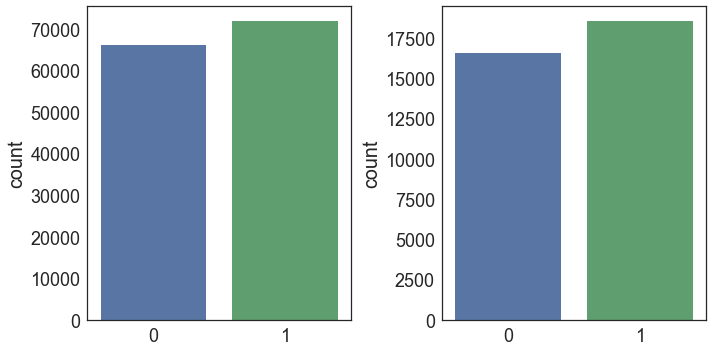

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_test, ax=axes[1])
fig.tight_layout()

# Training a random forest classifier

In [17]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [18]:
print(f'Accuracy score: {rf.score(X_test, y_test):.3f}')

Accuracy score: 0.880


# Visualising the results

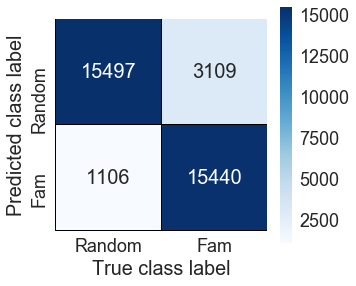

In [19]:
predicted = rf.predict(X_test)
test_probs = rf.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(5,5))
plotting.draw_confusion_matrix(y_test, predicted, class_labels={0: 'Random', 1: 'Fam'}, ax=ax)
fig.tight_layout()

fig.savefig('rf_confusion_matrix.png', dpi=300)

In [20]:
logistic = LogisticRegression(C=1e5, random_state=42)
logistic.fit(X_train, y_train)
logistic_test_probs = logistic.predict_proba(X_test)[:,1]

print(f'Accuracy score: {logistic.score(X_test, y_test):.3f}')

Accuracy score: 0.848


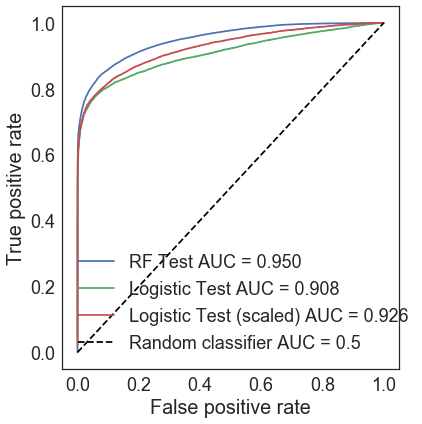

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
plotting.draw_roc_curve(y_test, test_probs, name='RF Test', ax=ax)
plotting.draw_roc_curve(y_test, logistic_test_probs, name='Logistic Test', ax=ax)
plotting.draw_roc_curve(y_test, logistic_test_probs_scaled, name='Logistic Test (scaled)', ax=ax)

ax.plot([0,1],[0,1], 'k--', label='Random classifier AUC = 0.5')
ax.legend(loc='best')
fig.tight_layout()

fig.savefig('roc_curve.png', dpi=300)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic.fit(X_train_scaled, y_train)
logistic_test_probs_scaled = logistic.predict_proba(X_test_scaled)[:,1]

print(f'Accuracy score: {logistic.score(X_test_scaled, y_test):.3f}')

Accuracy score: 0.856
